In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sktime.transformations.series.boxcox import LogTransformer
# from pycaret.time_series import TSForecastingExperiment
# from pycaret.time_series import *

# Load the dataset
data = pd.read_csv('./btc.csv')

# Display the first few rows of the dataset
data.head()

,Date,Open,High,Low,Close,Volume
0,2010-07-18,0.0,0.1,0.1,0.1,80.0
1,2010-07-19,0.1,0.1,0.1,0.1,570.0
2,2010-07-20,0.1,0.1,0.1,0.1,260.0
3,2010-07-21,0.1,0.1,0.1,0.1,580.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0


In [66]:
missing_values = data.isnull().sum()
print(missing_values)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    6
dtype: int64


Phân tích phân phối của các cột 

Summary Statistics:
                Open          High           Low         Close        Volume
count   4994.000000   4994.000000   4994.000000   4994.000000  4.988000e+03
mean   10754.806948  11007.469644  10485.664638  10766.334381  1.179480e+10
std    15798.109822  16176.285768  15385.079733  15811.764818  1.785750e+10
min        0.000000      0.100000      0.000000      0.100000  8.000000e+01
25%      226.600000    231.200000    222.400000    226.900000  5.895000e+04
50%     1871.600000   1954.500000   1825.050000   1909.250000  8.604240e+08
75%    15285.850000  15834.225000  14329.425000  15321.950000  2.049945e+10
max    73079.400000  73750.100000  71334.100000  73083.500000  3.509679e+11


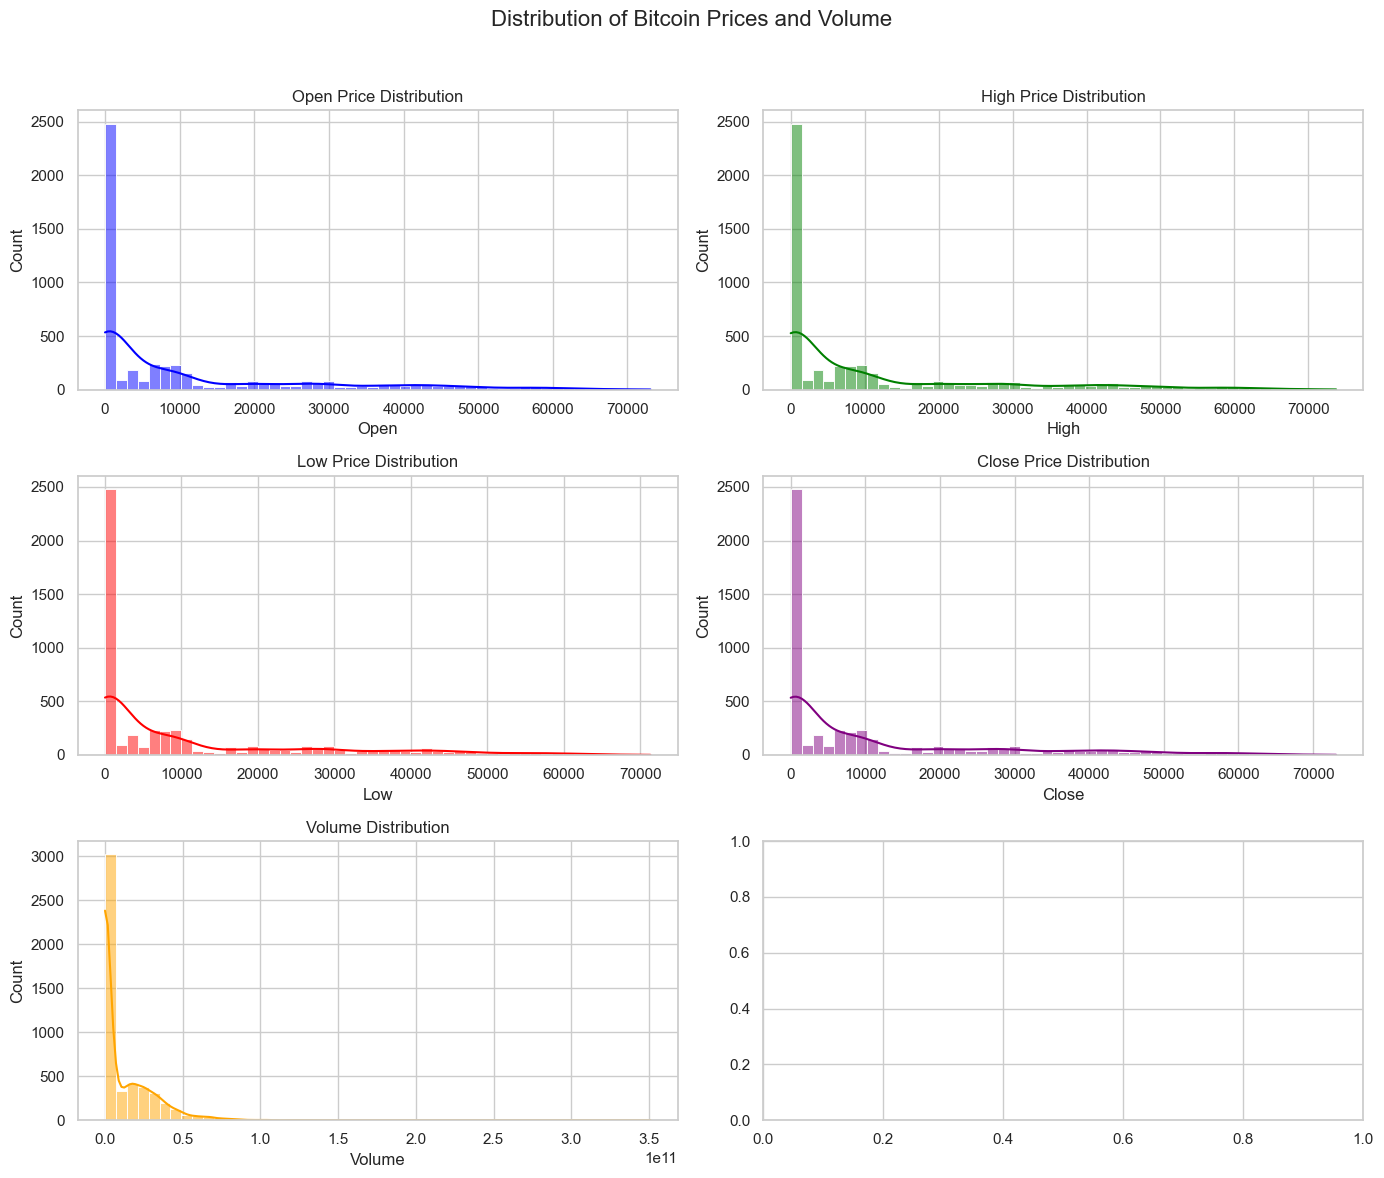

In [67]:
sns.set(style="whitegrid")

# Select only numerical columns for distribution analysis
numerical_data = data.select_dtypes(include=[np.number])

# Summary statistics for numerical columns
print("Summary Statistics:\n", numerical_data.describe())

# Histograms for distribution of each numerical column
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.suptitle('Distribution of Bitcoin Prices and Volume', fontsize=16)

sns.histplot(data=numerical_data, x='Open', bins=50, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Open Price Distribution')

sns.histplot(data=numerical_data, x='High', bins=50, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('High Price Distribution')

sns.histplot(data=numerical_data, x='Low', bins=50, kde=True, ax=axes[1, 0], color='red')
axes[1, 0].set_title('Low Price Distribution')

sns.histplot(data=numerical_data, x='Close', bins=50, kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Close Price Distribution')

sns.histplot(data=numerical_data, x='Volume', bins=50, kde=True, ax=axes[2, 0], color='orange')
axes[2, 0].set_title('Volume Distribution')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Xu hướng giá chung của bitcoin

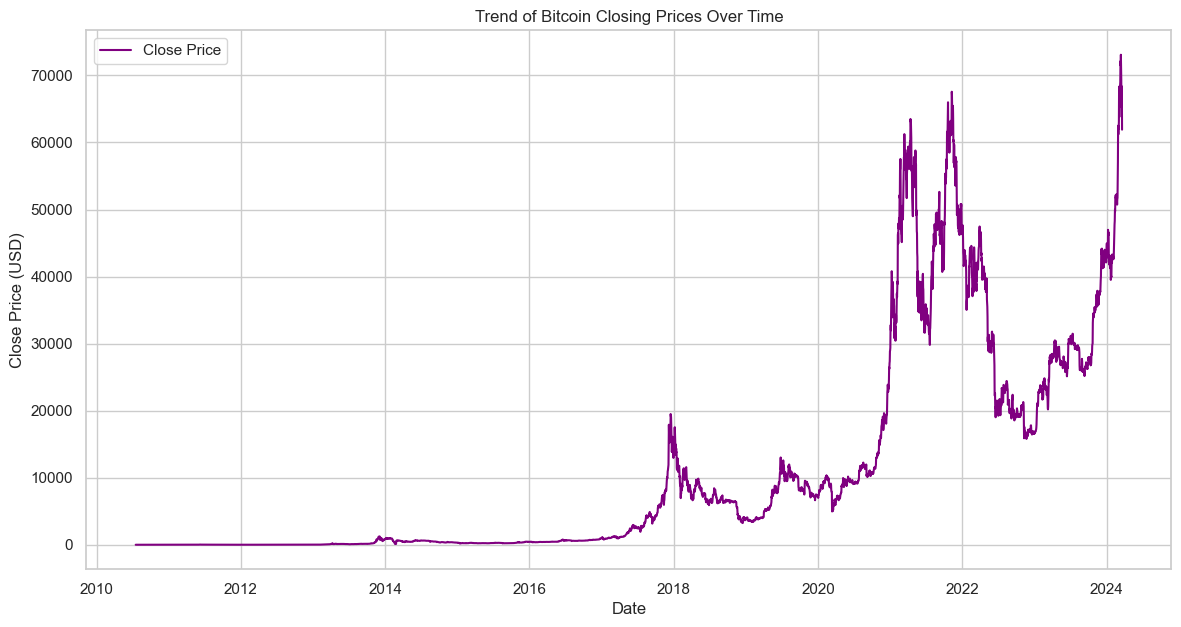

In [68]:
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index of the dataframe
data.set_index('Date', inplace=True)

# Plotting the overall trend of Bitcoin prices using a line chart
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price', color='purple')
plt.title('Trend of Bitcoin Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Xác định các giai đoạn thay đổi 

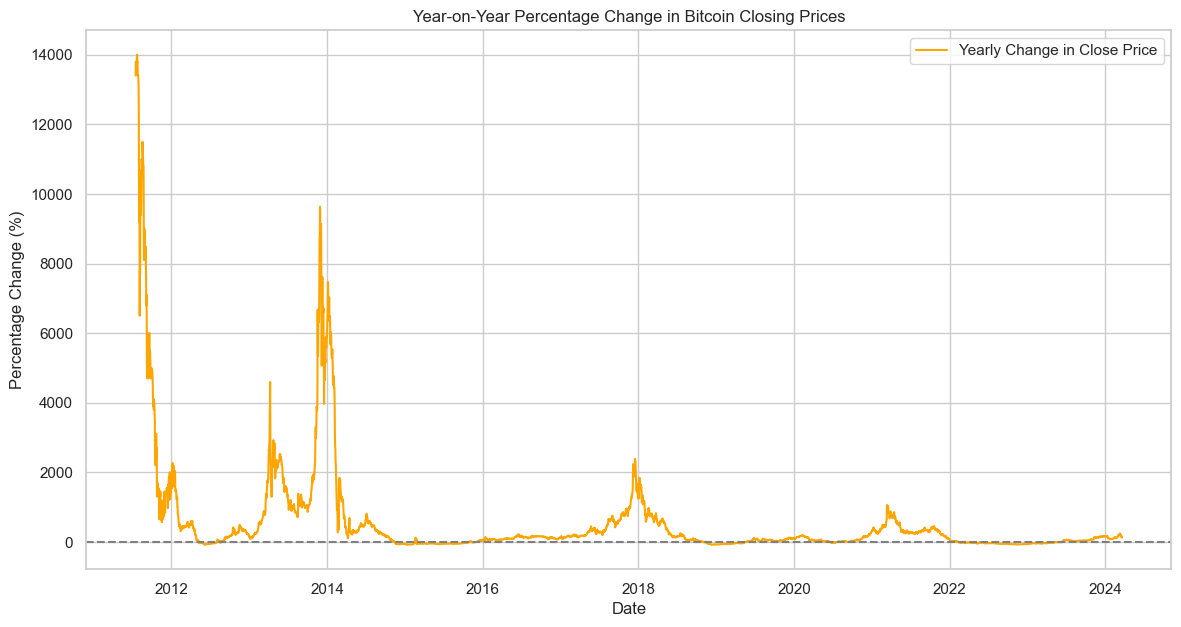

In [69]:
# Identifying significant periods of change
# We will look at the year-on-year percentage change to spot significant movements
data['Yearly Change'] = data['Close'].pct_change(365) * 100  # Calculate the percentage change year-on-year

# Plotting the yearly percentage change
plt.figure(figsize=(14, 7))
plt.plot(data['Yearly Change'], label='Yearly Change in Close Price', color='orange')
plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line at 0% change for reference
plt.title('Year-on-Year Percentage Change in Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True)
plt.show()

tính toán biến động hàng ngày(phạm vi giữa giá Cao và Thấp)

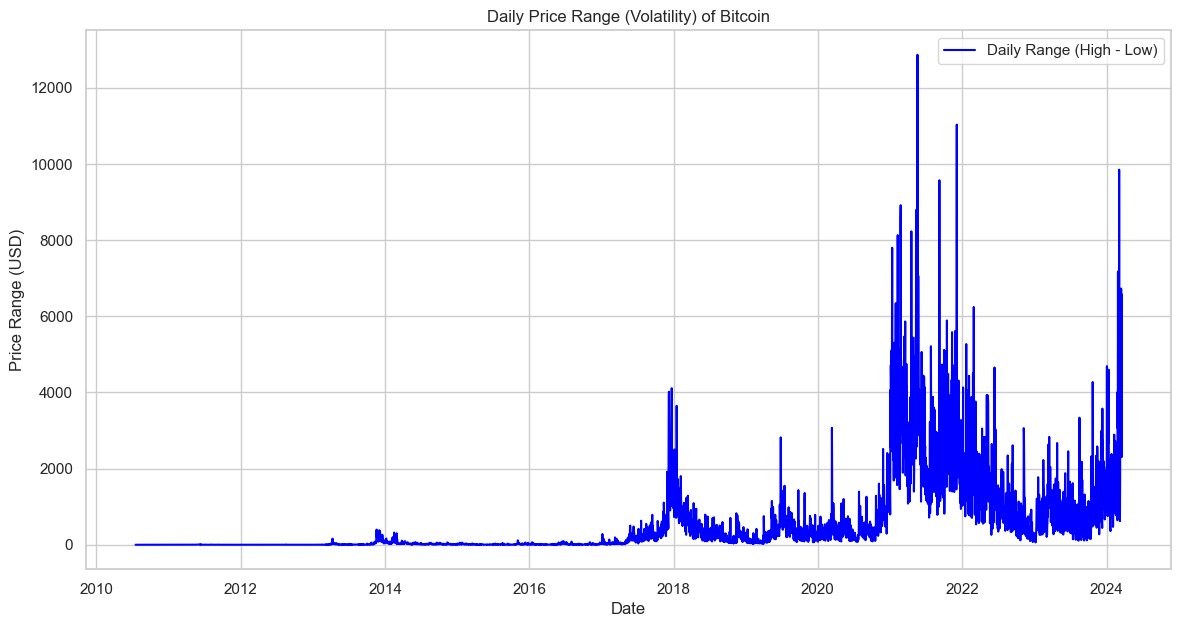

In [70]:
data['Daily Range'] = data['High'] - data['Low']

#Calculate rolling standard deviation for 7-day and 30-day windows
data['Rolling Std 7'] = data['Close'].rolling(window=7).std()
data['Rolling Std 30'] = data['Close'].rolling(window=30).std()

# Plotting the daily range to visualize daily volatility
plt.figure(figsize=(14, 7))
plt.plot(data['Daily Range'], label='Daily Range (High - Low)', color='blue')
plt.title('Daily Price Range (Volatility) of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price Range (USD)')
plt.legend()
plt.grid(True)
plt.show()



Vẽ độ lệch chuẩn lăn để hình dung xu hướng biến động theo thời gian

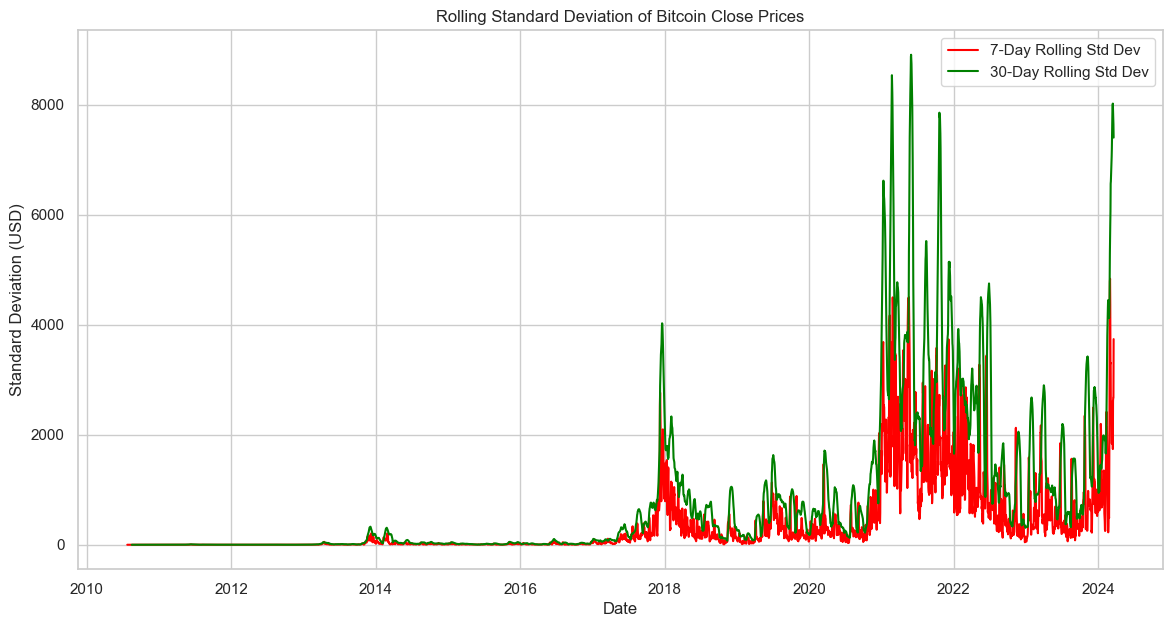

In [71]:
# Plotting rolling standard deviations to visualize trends in volatility over time
plt.figure(figsize=(14, 7))
plt.plot(data['Rolling Std 7'], label='7-Day Rolling Std Dev', color='red')
plt.plot(data['Rolling Std 30'], label='30-Day Rolling Std Dev', color='green')
plt.title('Rolling Standard Deviation of Bitcoin Close Prices')
plt.xlabel('Date')
plt.ylabel('Standard Deviation (USD)')
plt.legend()
plt.grid(True)
plt.show()

biến động theo mùa

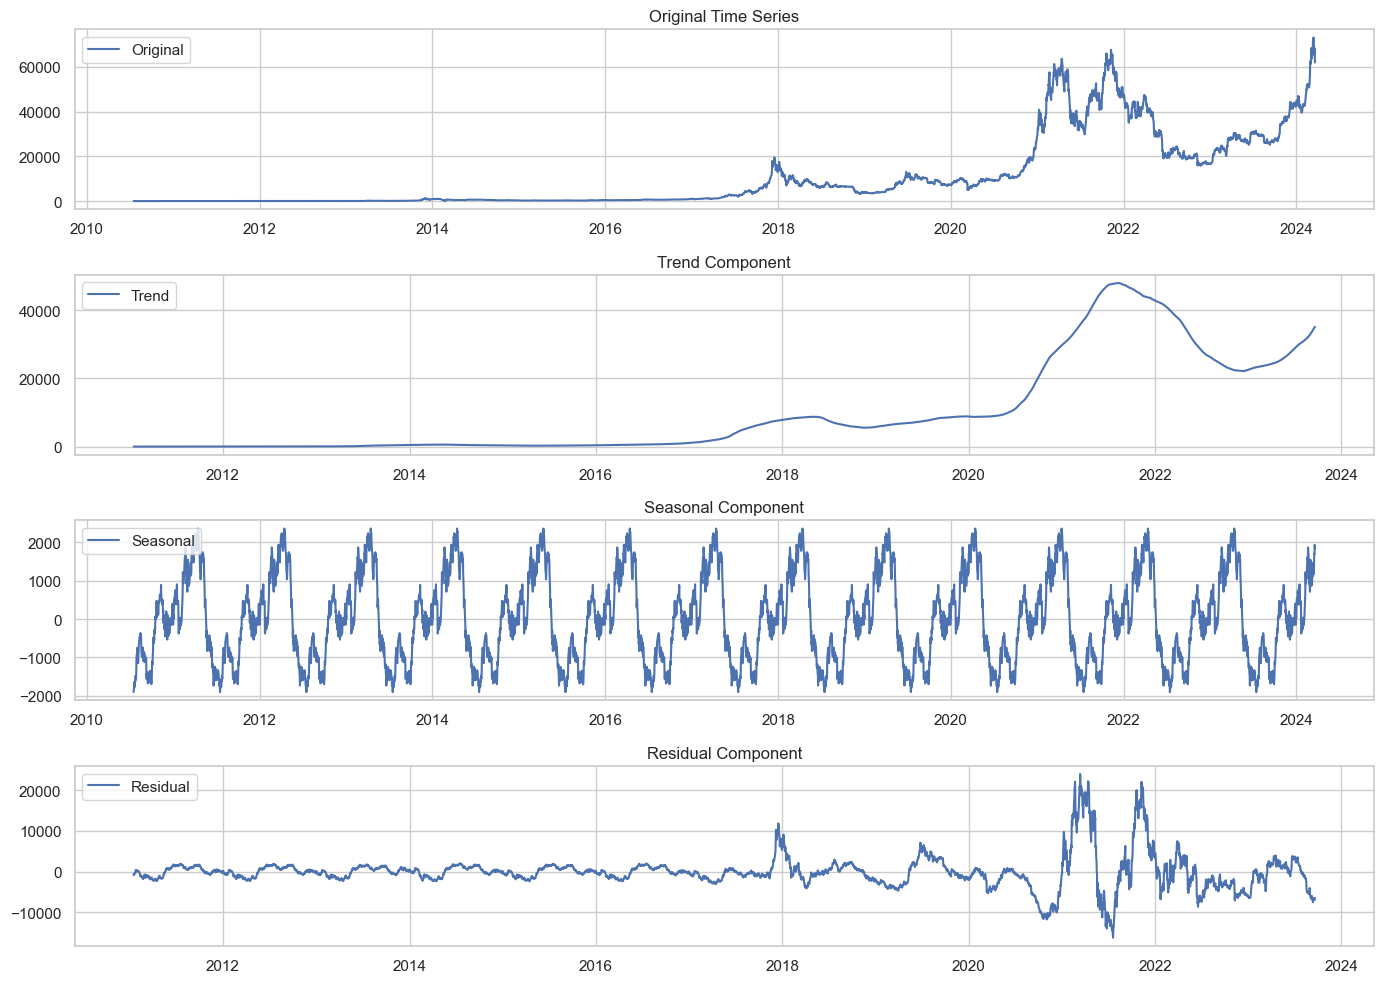

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Close'], model='additive', period=365)

# Vẽ các thành phần bị phân hủy của chuỗi thời gian 
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(result.observed, label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

Mô hình XGBoost 

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Prepare the data for modeling
X = data[['Open', 'High', 'Low', 'Volume']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate and print the performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 406.186


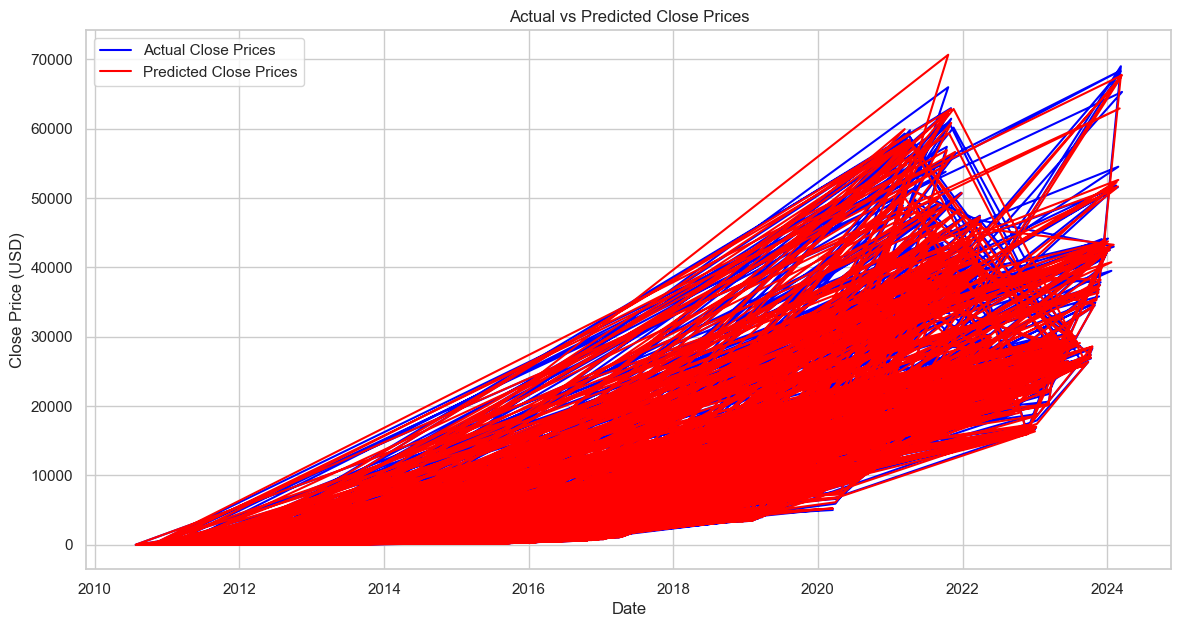

In [74]:
# Plot the actual vs predicted values for better visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Close Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Close Prices', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()